<a href="https://colab.research.google.com/github/ueki5/colaboratory/blob/main/playground-019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1
!pip install japanize-matplotlib | tail -n 1
!pip install plotly | tail -n 1

ERROR: Could not find a version that satisfies the requirement pprint (from versions: none)
ERROR: No matching distribution found for pprint


cuda:0
訓練データの件数: 50000
訓練データの型： <class 'torch.Tensor'>
訓練データのshape： torch.Size([3072])
最小値： tensor(-1.)
最大値： tensor(1.)
検証データの件数: 10000
検証データの型： <class 'torch.Tensor'>
検証データのshape： torch.Size([3072])
最小値： tensor(-0.8980)
最大値： tensor(1.)
num_data:100,num_data_test:20
inputs.shape: torch.Size([500, 3072])
labels.shape: torch.Size([500])
n_input: 3072, n_hidden: 128, n_output: 10
in=3072, out=128
in=128, out=10


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

開始　　22:29:11.802113
終了　　22:31:30.664954
処理　　00:02:18.862841
初期状態: 損失: 2.05401 精度: 0.29700
最終状態: 損失: 1.68076 精度: 0.41270


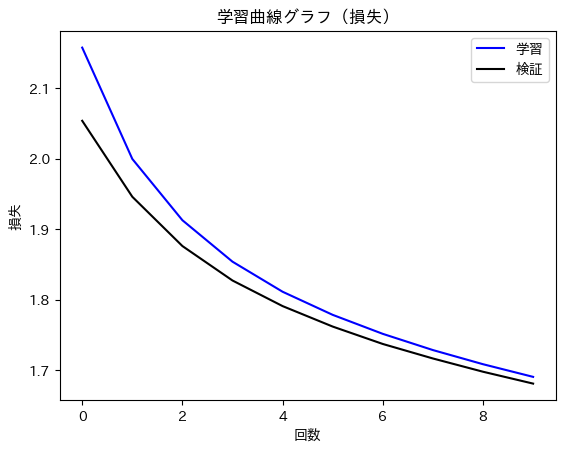

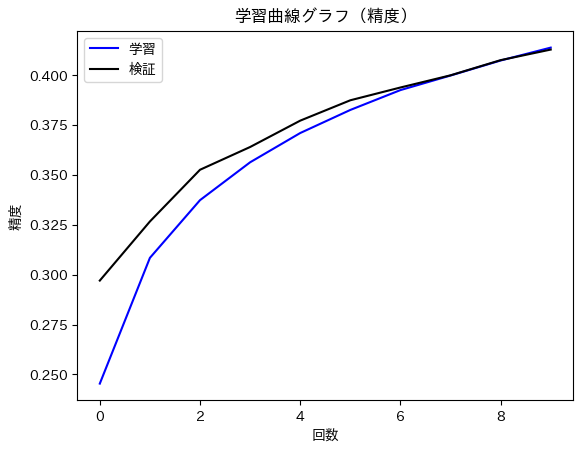

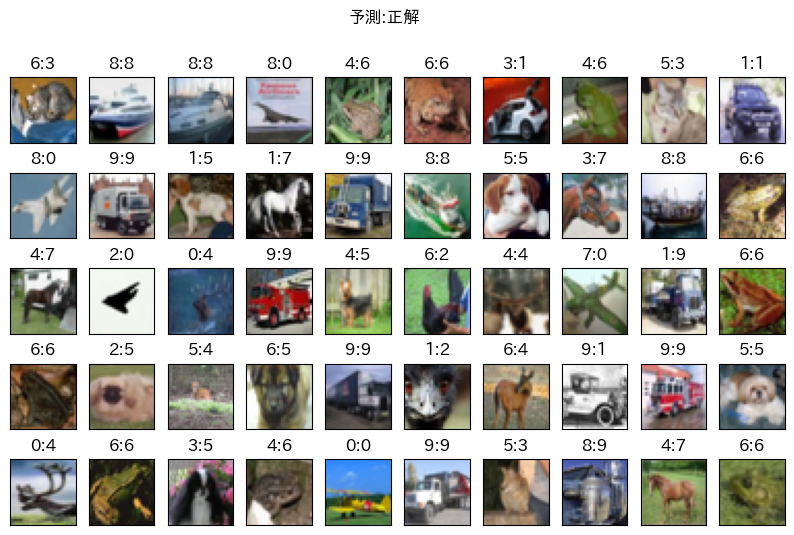

In [20]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
japanize_matplotlib.japanize()
from tqdm.notebook import tqdm
import torch
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchviz import make_dot

# 各種定数
batch_size = 500 # ミニバッチのサイズ指定
num_epochs = 10 # 繰り返し回数
lr = 0.01  # 学習率
dim_hidden = 128 # 隠れ層の次元数
dim_output = 10 # 出力層の次元数
num_layer = 2 # レイヤー数
use_cuda = True # CUDA使用

# デバイスの割り当て
if use_cuda:
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
else:
  device = torch.device("cpu")
print(device)

# ダウンロード先ディレクトリ名
data_root = './data'
# テンソル化 ＋ 正規化 ＋ １階テンソル化
transform = transforms.Compose([
  # データのテンソル化
  transforms.ToTensor(),
  # データの正規化(Normalize(μ, σ) ⇒ (x - μ) / σ)
  transforms.Normalize(0.5, 0.5),
  # # １階テンソル化
  transforms.Lambda(lambda x: x.view(-1)),
])
# 訓練データ
train_set = datasets.CIFAR10(
  root=data_root,
  train=True,
  download=True,
  transform=transform
)
# 検証データ
test_set = datasets.CIFAR10(
  root=data_root,
  train=False,
  download=True,
  transform=transform
)
# データ変換結果の確認
image, label = train_set[0]
print('訓練データの件数:', len(train_set))
print('訓練データの型：', type(image))
print('訓練データのshape：', image.shape)
print('最小値：', image.data.min())
print('最大値：', image.data.max())

image, label = test_set[0]
print('検証データの件数:', len(test_set))
print('検証データの型：', type(image))
print('検証データのshape：', image.shape)
print('最小値：', image.data.min())
print('最大値：', image.data.max())

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader = DataLoader(
    train_set,
    batch_size = batch_size,
    shuffle = True,
)
# 検証用データローダー
# 検証用にシャッフルは不要
test_loader = DataLoader(
    test_set,
    batch_size = batch_size,
    shuffle = False,
)

# データローダーの最初の１セットから、データの次元数を取得
inputs, labels = next(iter(train_loader))
# 入力次元数
n_input = inputs.shape[1] # 0:ミニバッチサイズ、1:入力次元数
# 出力次元数
n_output = dim_output
# 隠れ層の次元数
n_hidden = dim_hidden

###################################################
# 関数定義
###################################################
class Net(torch.nn.Module):
    def __init__(self, n_input, n_output, n_hidden, n_layer):
        super().__init__()

        # 予測関数
        layers = []
        for i in range(n_layer):
            _n_input = n_hidden
            _n_output = n_hidden
            if i == 0:
                _n_input = n_input
            if i == n_layer - 1:
                _n_output = n_output
            print(f'予測関数{i} 入力次元数:{_n_input}, 出力次元数:{_n_output}')
            layers.append(torch.nn.Linear(_n_input, _n_output))
        self.layers = torch.nn.ModuleList(layers)

        # ReLU関数
        self.relu = torch.nn.ReLU(inplace=True)

    # 予測関数
    def forward(self, inputs):
      x = self.layers[0](inputs)
      for layer in self.layers[1:]:
        x = self.relu(x)
        x = layer(x)
      return x

###########################
# メイン処理
###########################
num_data = len(train_loader)
num_data_test = len(test_loader)
print('入力層の次元数:', n_input)
print('中間層の次元数:', n_hidden)
print('出力層の次元数:', n_output)
print('バッチ繰返回数:', num_epochs)
print('ミニバッチサイズ:', batch_size)
print('ミニバッチ回数（訓練）:', num_data)
print('ミニバッチ回数（検証）:', num_data_test)

start_time = datetime.now()
# 予測計算オブジェクトの作成
net = Net(n_input, n_output, n_hidden, num_layer).to(device)
# 損失関数
criterion = torch.nn.CrossEntropyLoss()
# 最適化関数
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
# 記録用配列初期化()
history = np.zeros((0, 5))

# 学習＆検証
for epoch in range(num_epochs):
  ###########################
  # 履歴保存用変数
  ###########################
  # １エポック当たりの正解データ累積件数
  n_cum_train_acc = 0
  n_cum_test_acc = 0
  # １エポック当たりの累積損失（平均化前）
  cum_train_loss = 0
  cum_test_loss = 0
  # １エポック当たりのデータ累積件数
  n_cum_train = 0
  n_cum_test = 0

  ###########################
  # 学習
  ###########################
  for idx, (inputs, labels) in enumerate(tqdm(train_loader)):
    # 入力データをデバイスへ転送
    inputs = inputs.to(device)
    labels = labels.to(device)
    # 予測計算
    outputs = net(inputs)
    # 損失計算
    loss = criterion(outputs, labels)
    # 最初の１回のみ、計算グラフ（予測、損失）を描画
    if epoch == 0 and idx == 0:
        g = make_dot(loss, params = dict(net.named_parameters()))
        display(g)
    # 勾配計算
    loss.backward()
    # パラメータ調整
    optimizer.step()
    # 勾配クリア
    optimizer.zero_grad()
    # 損失の保存（スカラー値の取得）
    train_loss = loss.item()
    # 予測データ（0, 1, ... ,9）計算
    predicted = torch.max(outputs, 1)

    # １バッチ当たりのデータ件数
    train_batch_size = len(labels)
    # １エポック当たりのデータ累積件数
    n_cum_train += train_batch_size
    # 正解数の保存
    n_train_acc = (predicted.indices == labels).sum()
    # １エポック当たりの累積正解数
    n_cum_train_acc += n_train_acc
    # １エポック当たりの累積損失（平均化前）
    cum_train_loss += train_loss * train_batch_size

  ###########################
  # 検証
  ###########################
  for inputs_test, labels_test in tqdm(test_loader):
    # 入力データをデバイスへ転送
    inputs_test = inputs_test.to(device)
    labels_test = labels_test.to(device)
    # 予測計算
    outputs_test = net(inputs_test)
    # 損失計算
    loss = criterion(outputs_test, labels_test)
    # 損失の保存（スカラー値の取得）
    test_loss = loss.item()
    # 予測データ（0, 1, ... ,9）計算
    predicted_test = torch.max(outputs_test, 1)

    # １バッチ当たりのデータ件数
    test_batch_size = len(labels_test)
    # １エポック当たりのデータ累積件数
    n_cum_test += test_batch_size
    # 正解数の保存
    n_test_acc = (predicted_test.indices == labels_test).sum()
    # １エポック当たりの累積正解数
    n_cum_test_acc += n_test_acc
    # １エポック当たりの累積損失（平均化前）
    cum_test_loss += test_loss * test_batch_size

  ###########################
  # 履歴を保存
  ###########################
  item = np.array([
    epoch,
    cum_train_loss / n_cum_train,
    (n_cum_train_acc / n_cum_train).cpu(),
    cum_test_loss / n_cum_test,
    (n_cum_test_acc / n_cum_test).cpu(),
  ])
  history = np.vstack((history, item))

end_time = datetime.now()
td = end_time - start_time
total_us = td.seconds * 1_000_000 + td.microseconds
h = total_us // (3600 * 1_000_000)
m = (total_us // (60 * 1_000_000)) % 60
s = (total_us // 1_000_000) % 60
us = total_us % 1_000_000
print(f'開始　　{start_time.strftime("%H:%M:%S.%f")}')
print(f'終了　　{end_time.strftime("%H:%M:%S.%f")}')
print(f'処理　　{h:02}:{m:02}:{s:02}.{us:06}')

###############################################
# 結果表示
###############################################
# 損失と精度の確認
print(f'初期状態: 損失: {history[ 0, 3]:.5f} 精度: {history[ 0, 4]:.5f}')
print(f'最終状態: 損失: {history[-1, 3]:.5f} 精度: {history[-1, 4]:.5f}')

# 学習曲線グラフ（損失）
plt.plot(history[:, 0], history[:, 1], 'b', label='学習')
plt.plot(history[:, 0], history[:, 3], 'k', label='検証')
plt.xlabel('回数')
plt.ylabel('損失')
plt.title('学習曲線グラフ（損失）')
plt.legend()
plt.show()

# 学習曲線グラフ（精度）
plt.plot(history[:, 0], history[:, 2], 'b', label='学習')
plt.plot(history[:, 0], history[:, 4], 'k', label='検証')
plt.xlabel('回数')
plt.ylabel('精度')
plt.title('学習曲線グラフ（精度）')
plt.legend()
plt.show()

#######################################################
# 予測・正解サンプリング
# 正解データ付きで、最初のX0個をイメージ表示
#######################################################
# 画像データを取り直し
img_set = datasets.CIFAR10(
  root = data_root,
  train = False,
  download = True,
)
# 検証データを最初の500件だけ再計算
inputs_test, labels_test = next(iter(test_loader))
# 入力データをデバイスへ転送
inputs_test = inputs_test.to(device)
labels_test = labels_test.to(device)
# 予測計算
outputs_test = net(inputs_test)
# 予測データ（0, 1, ... ,9）計算
predicted_test = torch.max(outputs_test, 1)

# 最初のROW_NUM×COL_NUM件だけ、予測・正解データ付きでイメージを表示
ROW_NUM = 5
COL_NUM = 10
fig = plt.figure(figsize=(COL_NUM, ROW_NUM + 1))
plt.suptitle('予測:正解')
for i in range(COL_NUM * ROW_NUM):
  image, label = img_set[i]
  ax = plt.subplot(ROW_NUM, COL_NUM, i + 1)
  # イメージ表示
  plt.imshow(image)
  ax.set_title(f'{predicted_test.indices[i]}:{label}')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()
